In [1]:
%matplotlib qt
from pnc_spks import *
sortfolder = '/mnt/humanserver/temp_data/ephys/raw/191203_JC099_ephys_V1_JC/run03_speedup_8dir_whiskers_g3'

# Load the spiketimes and get average waveforms from the dat file
bin_file = pjoin(sortfolder,'run03_speedup_8dir_whiskers_g3_t0.imec.ap.bin')

spks = read_phy_data(sortfolder,bin_file=bin_file)
templates = np.stack(spks.mean_waveforms)
# Read the channelmap
chmap = read_phy_channelmap(sortfolder)
xy = np.array(chmap[['x','y']])
fig = plt.figure(figsize=[3,10])
def plot_single_template(itemplate = 0):
    fig.clf()
    plot_footprints(templates[itemplate],
                    xy,
                    gain=[6,1]);
from ipywidgets import interact,widgets
doplot = False
if doplot:
    interact(plot_single_template,itemplate = widgets.IntSlider(min=0,
                                               max=len(templates)-1,
                                               step=1,
                                               value=0));

Labels are from KS.
Reading mean waveforms from the binary file.


### Spike triggered rasters

In [2]:
# read sync channel
expname,sesname = sortfolder.strip('/').split('/')[-2:]
# remove gate
sesname = '_'.join(sesname.split('_')[:-1])
# load lfp
filename = bin_file.replace('ap.bin','lf.bin')
dat,meta = load_spikeglx_binary(filename)
srate = meta['imSampRate']
onsets,offsets = unpack_npix_sync(dat[:,-1],srate);
# get the stim times for the puff and visual
externalmount = '/mnt/humanserver/temp_data/presentation'
logfile = pjoin(externalmount,expname,sesname+'.log')
from pyvstim import parseVStimLog, getStimuliTimesFromLog
stimtimes,stimpars,stimops = getStimuliTimesFromLog(logfile)
vstimn = np.unique(stimtimes[:,0])
stimidx = np.arange(len(vstimn))
# drop puff stimuli if present
if 'puff' in stimpars.columns:
    stimidx = np.where(stimpars.puff == 0)[0]
    event_on_off = np.vstack([onsets[7],offsets[7]]).T
    idx = np.hstack([0,np.where(np.diff(event_on_off[:,0],axis = 0)>0.2)[0]+1])
    puffonset = event_on_off[idx,0]
    puffdur = np.ceil(np.diff(event_on_off,axis = 1)).mean()
vstimn = vstimn[stimidx]
vstimdur = np.array(stimpars.dur.iloc[stimidx])
vstimtimes = stimtimes
vstimtimes[:,2] = onsets[0]
vstimtimes[:,3] = offsets[0]
vstimtimes = vstimtimes[np.argsort(vstimtimes[:,0]),:]
# compute triggered spike events for all units
tpre = 1
vtrig_events = []
ptrig_events = []
vtrig_counts = []
ptrig_counts = []
from tqdm import tqdm
for sp in tqdm(spks.ts.iloc[:]):
    vtrig_events.append([]) # one per unit
    ptrig_events.append([]) 
    vtrig_counts.append([]) 
    ptrig_counts.append([]) 
    for i,iStim in enumerate(vstimn):
        ons = vstimtimes[vstimtimes[:,0] == iStim,2]
        stim_dur = vstimdur[i]
        win = [-tpre,stim_dur + tpre] # window to extract events
        tmp = []
        tmp_cnts = []
        for on in ons:
            tmp.append(sp[(sp>win[0]+on) & (sp<win[1]+on)] - on)
        vtrig_events[-1].append(tmp) # one per stim
        frpre = [len(t[t<=0])/tpre for t in tmp]
        frdur = [len(t[(t>0) & (t<=stim_dur)])/stim_dur for t in tmp]
        vtrig_counts[-1].append(np.vstack([frpre,frdur]).T)
    vtrig_counts[-1] = np.stack(vtrig_counts[-1])
    if 'puff' in stimpars.columns:
        tmp = []
        win = [-tpre,puffdur + tpre]
        for on in puffonset:
            tmp.append(sp[(sp>win[0]+on) & (sp<win[1]+on)] - on)
        ptrig_events[-1] = tmp
        frpre = [len(t[t<=0])/tpre for t in tmp]
        frdur = [len(t[(t>0) & (t<=puffdur)])/puffdur for t in tmp]
        ptrig_counts[-1] = np.vstack([frpre,frdur]).T

spks['trig_puff'] = ptrig_events
spks['trig_vstim'] = vtrig_events
spks['frate_puff'] = ptrig_counts
spks['frate_vstim'] = vtrig_counts

from scipy.stats import ranksums
rksum_vis = []
rksum_puff = []
for fr in tqdm(spks.frate_puff.iloc[:]):
    pval = ranksums(fr[:,0],fr[:,1]).pvalue
    rksum_puff.append(pval)
spks['ranksum_puff'] = rksum_puff
bspks_puff = []
nsamples_puff = []
for iunit,sp in tqdm(enumerate(spks.trig_puff.iloc[:])):
    binsize = 0.001
    edges = np.arange(-tpre,puffdur+tpre,binsize)
    bspks = binary_spikes(sp,edges,sigma = 5,kernel=None)/binsize
    bspks_puff.append(bspks)
    mm = np.mean(bspks,axis = 0)
    s = np.nanstd(bspks[:,:tpre*1000])
    if s>0:
        m = np.nanmean(bspks[:,:tpre*1000])
        cnt = np.sum(np.abs(mm-m)>=(s*1.5))
    else:
        cnt = 0
    nsamples_puff.append(cnt)
spks['bspks_puff'] = bspks_puff
spks['tthresh_puff'] = nsamples_puff    

100%|██████████| 696/696 [00:00<00:00, 2538.69it/s]
696it [00:12, 57.67it/s]


In [3]:
plt.figure(figsize = [4,4])
plt.title('V1')
plt.plot([0,80],[0,80],'k',lw=0.5)
crtxchan = np.min(chmap.ichan[chmap.y>2800])
frs = np.stack(spks.frate_puff).mean(axis = 1)
idx = np.where(spks.peak_channel < crtxchan)[0]
plt.plot(frs[idx,0],frs[idx,1],'.',color = 'gray',markersize = 4,alpha = 0.6,label='sub-cortical')

frs = np.stack(spks[spks.peak_channel >= crtxchan].frate_puff).mean(axis = 1)
#idx = np.where(spks[spks.peak_channel >= crtxchan].cluster_label == 'mua')[0]

#plt.plot(frs[idx,0],frs[idx,1],'x',color = 'k',alpha = 0.8,label='mua')
idx = np.where(spks[spks.peak_channel >= crtxchan].cluster_label == 'good')[0]
plt.plot(frs[idx,0],frs[idx,1],'o',color = colors[2],alpha = 0.8,label='sua',ms=4)

plt.axis([0,80,0,80])
plt.xlabel('pre-stim (rate spks/s)')
plt.ylabel('stim (rate spks/s)')


Text(0, 0.5, 'stim (rate spks/s)')

In [68]:
plt.plot(mm-m)
plt.hlines(s*1.5,0,2500)

In [66]:
s

0.0

In [14]:
# plot the rasters
%matplotlib notebook

fig1 = plt.figure(figsize=[6,6])
#untrials = np.cumsum([np.sum(stimtimes[:,0]==i) for i in np.unique(stimtimes[:,0])])
#untrials = np.hstack([untrials[:8],len(stim_onset[0])])
pval_sel = np.where(spks.tthresh_puff>100)[0]

def interact_raster(iunit = 9):
    plt.figure(fig1.number)
    plt.clf()
    #iunit = pval_sel[iunit]
    fig1.add_axes([0.1,0.80,.35,.15])
    y = [np.ones_like(t)*i for i,t in enumerate(spks.trig_puff.iloc[iunit])]
    x = spks.trig_puff.iloc[iunit]
    #plt.plot(np.hstack(x),np.hstack(y),'k|',markersize=2)
    plot_raster(spks.trig_puff.iloc[iunit])
    ntrials = len(x)
    plt.vlines([0,puffdur],0,ntrials,color = colors[1],lw = 0.5)
    plt.axis([-tpre+.5,puffdur+tpre-.5,0,ntrials])
    plt.xticks([])
    plt.yticks([])
    plt.title('{0} {1} {2} puff:{3:1.2f}'.format(iunit,
                                                 spks.cluster_id.iloc[iunit],
                                                 spks.cluster_label.iloc[iunit],
                                                 spks.ranksum_puff.iloc[iunit]))
    fig1.add_axes([0.1,0.64,.35,.15])
    binsize = 0.001
    edges = np.arange(-tpre,puffdur+tpre,binsize)
    bspks = binary_spikes(spks.trig_puff.iloc[iunit],edges,2)/binsize
    bspks = bspks.mean(axis=0)
    plt.plot(edges[1:],bspks,color=colors[2])
    plt.vlines([0,puffdur],0,np.max(bspks),color = colors[1],lw = 0.5)
    plt.axis([-tpre+0.5,puffdur+tpre-0.5,0,np.max(bspks)])

    fig1.add_axes([0.1,0.26,.35,.3])
    y = [np.ones_like(t)*(j+(i*len(tt))) for i,tt in enumerate(spks.trig_vstim.iloc[iunit]) for j,t in enumerate(tt)]
    x = [tt for t in spks.trig_vstim.iloc[iunit] for tt in t]
    [plot_raster(t,offset = i*len(t)) for i,t in enumerate(spks.trig_vstim.iloc[iunit])]
    #plt.plot(np.hstack(x),np.hstack(y),'k|',markersize=2)
    nstims = len(spks.trig_vstim.iloc[iunit])
    ntrials = len(x)/nstims
    plt.vlines([0,vstimdur[0]],0,ntrials*nstims,color = colors[1],lw = 0.5)
    plt.hlines(np.arange(0,ntrials*nstims,ntrials),-tpre,tpre+vstimdur[0],
               color = colors[2],lw = 1)
    plt.axis([-tpre+0.5,vstimdur[0]+tpre-0.5,0,np.max(ntrials*nstims)])
    plt.xticks([])
    plt.yticks([])
    fig1.add_axes([0.1,0.1,.35,.15])
    binsize = 0.001
    for i,s in enumerate(spks.trig_vstim.iloc[iunit]):
        edges = np.arange(-tpre,vstimdur[0]+tpre,binsize)
        bspks = binary_spikes(s,edges,5)/binsize
        bspks = bspks.mean(axis=0)
        plt.plot(edges[1:],bspks,color=colors[i],alpha = 1)
    plt.vlines([0,vstimdur[0]/2.,vstimdur[0]],0,np.max(plt.ylim()),color = colors[1],lw = 0.5)
    plt.axis([-tpre+0.5,vstimdur[0]+tpre-0.5,0,np.max(plt.ylim())])

    
    fig1.add_axes([0.8,0.03,.18,.93])
    waves = spks.mean_waveforms.iloc[iunit]
    offset = 1
    for i,ch in enumerate(waves.T):
        x,y = chmap.x.iloc[i],chmap.y.iloc[i]
        plt.plot(np.linspace(0,6,len(ch))+x,ch/offset+y,alpha = 1,lw=1,color = 'k')
    plt.plot([70,70],[3840,2840],color = 'k')
    ptb = waves[20:50,:].max(axis=0) - waves[20:50,:].min(axis=0) # peak to baseline per channel 
    i = np.argmax(np.abs(ptb)) # peak chan
    x,y = chmap.x.iloc[i],chmap.y.iloc[i]
    plt.plot(x,y,'*',color = 'r')
    plt.axis('off')
    
interact_raster(0)
from ipywidgets import interact,widgets
interact(interact_raster,iunit = widgets.IntSlider(min=0,
                                           max=len(spks)-1,
                                           step=1,
                                           value=0))

interactive(children=(IntSlider(value=0, description='iunit', max=695), Output()), _dom_classes=('widget-inter…

<function __main__.interact_raster(iunit=9)>

In [15]:
fig1 = plt.figure(figsize=[6,6])

foldname = '/mnt/tmp/rasters_V1'
if not os.path.isdir(foldname):
    os.makedirs(foldname)
for iunit in range(len(spks)-1):
    plt.clf()
    interact_raster(iunit)
    plt.savefig(pjoin(foldname,'unit_{0}.pdf'.format(iunit)))

/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


In [7]:
frpre = []
frdur = []
frpost = []
for tt in spks.trig_puff:    
    frpre.append(np.nanmean([len(t[t<=0]) for t in tt[0]]))
    frdur.append(np.nanmean([len(t[(t>0) & (t<1)]) for t in tt[0]]))
    frpost.append(np.nanmean([len(t[(t>1)]) for t in tt[0]]))
frpre = np.array(frpre)
frdur = np.array(frdur)
frpost = np.array(frpost)


/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [83]:
frs = np.stack(spks.frate_puff)


(696, 2)

NameError: name 'ap_meta' is not defined

In [7]:
plt.figure(figsize = [4,4])
plt.title('V1')
plt.plot([0,120],[0,120],'k',lw=0.5)
frs = np.stack(spks.frate_puff).mean(axis = 1)
idx = np.where(spks.peak_channel < crtxchan)[0]
plt.plot(frs[idx,0],frs[idx,1],'.',color = 'gray',markersize = 4,alpha = 0.6,label='sub-cortical')
crtxchan = np.min(chmap.ichan[chmap.y>2800])

frs = np.stack(spks[spks.peak_channel >= crtxchan].frate_puff).mean(axis = 1)
idx = np.where(spks[spks.peak_channel >= crtxchan].cluster_label == 'mua')[0]

plt.plot(frs[idx,0],frs[idx,1],'x',color = 'k',alpha = 0.8,label='mua')
idx = np.where(spks[spks.peak_channel >= crtxchan].cluster_label == 'good')[0]
plt.plot(frs[idx,0],frs[idx,1],'o',color = colors[2],alpha = 0.8,label='sua',ms=4)

plt.axis([0,120,0,120])
plt.xlabel('pre-stim (rate spks/s)')
plt.ylabel('stim (rate spks/s)')


Text(0, 0.5, 'stim (rate spks/s)')

In [4]:

lfp = get_npix_lfp_triggered(dat,meta,puffonset,puffdur)
#lfp = get_npix_lfp_triggered(dat,meta,vstimtimes[vstimtimes[:,0]<9,2],1)
mlfp = np.mean(lfp[:,:,:],axis = 0)

flfp = bandpass_filter(mlfp,srate,[5,50])
csd,ny = current_source_density(flfp.T,chmap)


100%|██████████| 60/60 [00:06<00:00,  8.99it/s]


In [85]:
idx = np.array(chmap.ichan)
mlfp


ichan     x       y
0        1  11.0    20.0
1        5  11.0    60.0
2        9  11.0   100.0
3       10  59.0   120.0
4       11  27.0   120.0
..     ...   ...     ...
315    378  59.0  3800.0
316    380  43.0  3820.0
317    381  11.0  3820.0
318    382  59.0  3840.0
319    383  27.0  3840.0

[320 rows x 3 columns]

In [6]:
%matplotlib qt
duration = puffdur
fig = plt.figure(figsize=[10,10])
#plt.plot(lfp.T + np.arange(lfp.shape[0])*100.,color='k')
fig.add_axes([0.1,0.1,0.5,0.8])
clim = np.array([-1.,1.])*np.abs(np.max(np.median(csd,axis=0)))*30.
clim = [-60,60]
plt.imshow(csd,aspect='auto',origin='lower',
           interpolation='none',clim=clim,
           extent=[-tpre,float(duration+tpre),np.min(chmap.y),np.max(chmap.y)],cmap='Spectral_r')
plt.colorbar(shrink=0.5)
# fig.add_axes([0.7,0.1,0.2,0.8])
everyother = flfp[:,::10]
everyother = everyother/np.max(everyother)
plt.plot(np.linspace(-tpre,float(tpre+duration),everyother.shape[0])
         ,everyother*20 + np.linspace(np.min(chmap.y),np.max(chmap.y),everyother.shape[1]),'k',
         clip_on=True)
plt.axis('tight')
plt.ylim([0,3800])
plt.savefig('/mnt/tmp/csd_V1.pdf',dpi=500)

(776, 7500)

In [383]:
from scipy.interpolate import interp2d
from scipy.signal import ellip, filtfilt,butter

def get_npix_lfp_triggered(dat,meta,onsets,dur=1,tpre=1,car_subtract = True):
    srate = meta['imSampRate']
    lfp = []
    idx = np.arange(-tpre*srate,(dur + tpre)*srate,1,dtype = int)
    for i in tqdm(onsets):
        tmp = dat[int(i*srate)+idx,:]
        if car_subtract:
            tmp = (tmp.T - np.median(tmp,axis=1)).T
            tmp = tmp - np.median(tmp,axis=0)
        lfp.append(tmp)
    lfp = np.stack(lfp)
    gain = np.float32(meta['~imroTbl'][1].split(' ')[3])
    microv_per_bit = ((meta['imAiRangeMax'] - meta['imAiRangeMin'])/(2**16))/gain*1e6
    lfp *= microv_per_bit
    return lfp

def bandpass_filter(X,srate,band=[3,300]):
    b, a = ellip(4, 0.1, 40, np.array(band)/(srate/2.),btype='bandpass')
    return filtfilt(b, a, X,axis = 0)#, method="gust"

def current_source_density(lfp,chmap, chanspacing=60, interpolate=False):
    # Interpolate so that we get even sampling
    selchannels = np.array(chmap.ichan)
    ux = np.unique(chmap.x)
    ix = np.argmax([np.sum(chmap.x==u) for u in ux])
    chidx = chmap.x==ux[ix]
    y = np.array(chmap[chidx].y)
    duration = lfp.shape[1]
    x = np.arange(duration)
    z = lfp[chmap[chidx].ichan,:]
    f = interp2d(x,y,z)
    ny = np.arange(np.min(y)-chanspacing,np.max(y)+chanspacing,chanspacing)
    nlfp = f(x,ny)
    # duplicate outmost channels
    csd = np.empty((nlfp.shape[0]-2,nlfp.shape[1]))
    smoothed_lfp = np.empty_like(nlfp)
    for i in range(csd.shape[0]):
        smoothed_lfp[i+1,:] = (1./4.) *(nlfp[i,:] + 2.*nlfp[i+1,:] + nlfp[i+2,:])
    smoothed_lfp[0,:] = (1./4.) *(3.*nlfp[0,:] + nlfp[1,:])
    smoothed_lfp[-1,:] = (1./4.) *(3.*nlfp[-1,:] + nlfp[-2,:])
    smoothed_lfp = smoothed_lfp
    for i in range(csd.shape[0]):
        csd[i,:] = -(1./(chanspacing*1.e-3)**2.)*(smoothed_lfp[i,:]-2.*smoothed_lfp[i+1,:]+smoothed_lfp[i+2,:])
    f = interp2d(x,np.linspace(np.min(y)-chanspacing,np.max(y)+chanspacing,csd.shape[0]),csd)
    ny = np.arange(np.min(y)-chanspacing,np.max(y)+chanspacing,5.)
    return f(x,ny),smoothed_lfp[:,1:-1]

def alpha_function(N, amplitude = 1, t_rise = 2, t_decay = 250, srate = 1000.,norm = True):

    t_rise = t_rise/srate;
    t_decay = t_decay/srate;
    
    fun_max  = (t_rise*t_decay/(t_decay-t_rise)) * np.log(t_decay-t_rise);
    normalization_factor = 1; #%(exp(-fun_max/t_rise) - exp(-fun_max/t_decay))/(t_rise-t_decay);
    ii = np.arange(0,N)
    kernel = np.hstack([np.zeros(N),
                        amplitude*(1.0/(normalization_factor*(t_decay-t_rise))) * (np.exp(-((ii/srate)/t_decay))
                                                                                   - np.exp(-(ii/srate)/t_rise))])
    if norm:
        kernel /= np.sum(kernel)
    return kernel

def binary_spikes(spks,edges,sigma=None,kernel = None):
    ''' Create a vector of binary spikes.

    binsize = 0.001
    edges = np.arange(0,5,binsize)
    bspks = binary_spikes(spks,edges,5)/binsize

    Joao Couto - March 2016
    '''
    bins = [np.histogram(sp,edges)[0] for sp in spks]
    if not sigma is None:
        # Convolve spk trains
        x = np.arange(np.floor(-3*sigma),np.ceil(3*sigma))
        kernel = np.exp(-(x/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))
    if not kernel is None:
        bins = [np.convolve(a,kernel,'same') for a in bins]
    return np.vstack(bins)


In [ ]:
lfp = np.mean(lfps,axis=1)
#lfp = (lfp.T - np.median(lfp,axis=1)).T
from scipy.interpolate import interp2d
from scipy.signal import ellip, filtfilt,butter
#plt.plot(lfp.T + np.arange(lfp.shape[0])*100.,color='k')
#plt.plot(nlfp.T + np.arange(nlfp.shape[0])*200.)
#plt.show()

b, a = ellip(4, 0.1, 40, np.array([2.,300.])/(srate/2.),btype='bandpass')
#b, a = butter(4, np.array([.1,150.])/(srate/2.),btype='bandpass')
lfp = filtfilt(b, a, lfp)#, method="gust"

def whiten(X,fudge=1E-10):
    # the matrix X should be observations-by-components
    # get the covariance matrix
    Xcov = np.dot(X.T,X)
    # eigenvalue decomposition of the covariance matrix
    d, V = np.linalg.eigh(Xcov)
    # a fudge factor can be used so that eigenvectors associated with
    # small eigenvalues do not get overamplified.
    D = np.diag(1. / np.sqrt(d+fudge))
    # whitening matrix
    W = np.dot(np.dot(V, D), V.T)
    # multiply by the whitening matrix
    X_white = np.dot(X, W)
    return X_white, W

def svd_whiten(X):
    U, s, Vt = np.linalg.svd(X,full_matrices=False)
    print U.shape, s.shape, Vt.shape
    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white
    X_white = np.dot(U, Vt)

    return X_white

#wlfp = svd_whiten(lfp.T)
wlfp = lfp

def compute_current_source_density(lfp,chmap, chanspacing=20, interpolate=False):
    # Interpolate so that we get even sampling
    selchannels = np.array(chmap.Data[chmap.X == 0])
    y = np.array(chmap.Y[chmap.X == 0])
    x = np.arange(duration)
    z = lfp[selchannels,:]
    f = interp2d(x,y,z)
    ny = np.arange(np.min(chmap.Y)-chanspacing,np.max(chmap.Y)+chanspacing,chanspacing)
    nlfp = f(x,ny)
    # duplicate outmost channels
    csd = np.empty((nlfp.shape[0]-2,nlfp.shape[1]))
    smoothed_lfp = np.empty_like(nlfp)
    for i in range(csd.shape[0]):
        smoothed_lfp[i+1,:] = (1./4.) *(nlfp[i,:] + 2.*nlfp[i+1,:] + nlfp[i+2,:])
    smoothed_lfp[0,:] = (1./4.) *(3.*nlfp[0,:] + nlfp[1,:])
    smoothed_lfp[-1,:] = (1./4.) *(3.*nlfp[-1,:] + nlfp[-2,:])
    smoothed_lfp = smoothed_lfp
    for i in range(csd.shape[0]):
        csd[i,:] = -(1./(chanspacing*1.e-3)**2.)*(smoothed_lfp[i,:]-2.*smoothed_lfp[i+1,:]+smoothed_lfp[i+2,:])
    f = interp2d(x,np.linspace(np.min(chmap.Y)-chanspacing,np.max(chmap.Y)+chanspacing,csd.shape[0]),csd)
    ny = np.arange(np.min(chmap.Y)-chanspacing,np.max(chmap.Y)+chanspacing,5.)
    return f(x,ny),smoothed_lfp[:,1:-1]
csd,nlfp = compute_current_source_density(wlfp,chmap)

fig = plt.figure(figsize=[10,10])
#plt.plot(lfp.T + np.arange(lfp.shape[0])*100.,color='k')
fig.add_axes([0.1,0.1,0.5,0.8])
plt.imshow(csd,aspect='auto',origin='lower',
           interpolation='none',clim=np.array([-1.,1.])*np.abs(np.max(np.median(csd,axis=0)))*30.,
           extent=[0,1000*float(duration)/srate,np.min(chmap.Y),np.max(chmap.Y)],cmap='Spectral_r')
plt.colorbar(shrink=0.5)
everyother = nlfp[::2,:].T
everyother = everyother/np.max(everyother)
plt.plot(np.linspace(0,1000*float(duration)/srate,everyother.shape[0])
         ,everyother*20 + np.linspace(np.min(chmap.Y),np.max(chmap.Y),everyother.shape[1]),'k',
         clip_on=False)
plt.axis('tight')
cleanAx(plt.gca())
fig.add_axes([0.7,0.1,0.2,0.8])
everyother = csd[::7,:].T
everyother = everyother/np.max(np.abs(everyother))
time = np.linspace(0,1000*float(duration)/srate,everyother.shape[0])
plt.plot(time
         ,everyother*20 + np.linspace(np.min(chmap.Y),np.max(chmap.Y),everyother.shape[1]),'k',
         clip_on=False)
plt.axis('tight')
cleanAx(plt.gca())

fig.savefig('/home/joao/Desktop/'+expname+'csd_csd.pdf',dpi=600,format='pdf')
plt.show()


In [119]:

plot_raster?

In [228]:
sel = [130,141,144,145,149,151,152,156,157,158,160,161,162,165,170,177,178,180,198,
      203,207,209,214,215,216,217,222,225,226,227,231,234,240,241,243,245,246,247,249,
      252,255,256,257,258,259,260,261,262,263,264,267,270,271,272,274,275,277,278,279,
      280,283,285,287,289,290,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,
      315,317,319,328,330,331,333,334,335,336,342,354,382,383,384,385,387,388,389,391,393,
      398,399,400,401,402,404,406,409,411,412,413,414,415,416,417,418,419,420,421,422,423,
      425,426,427,428,429,436,440,446,451,452,454]

/opt/conda/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


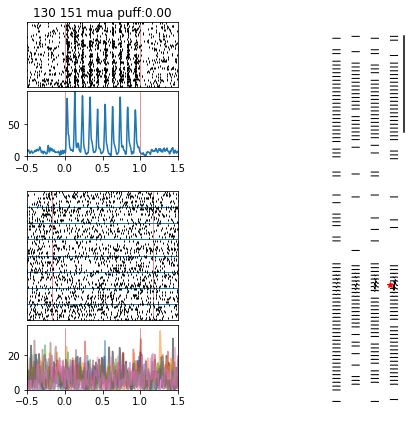

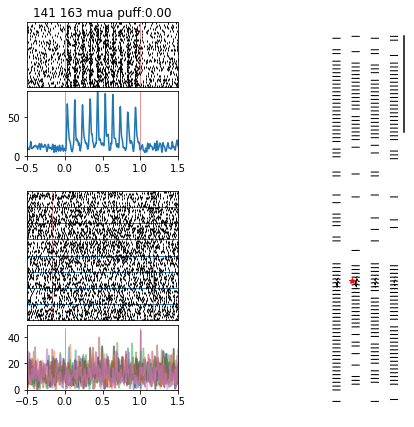

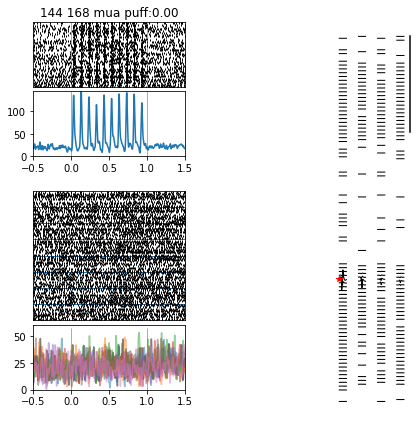

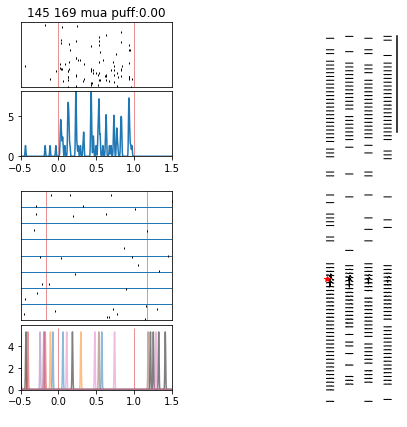

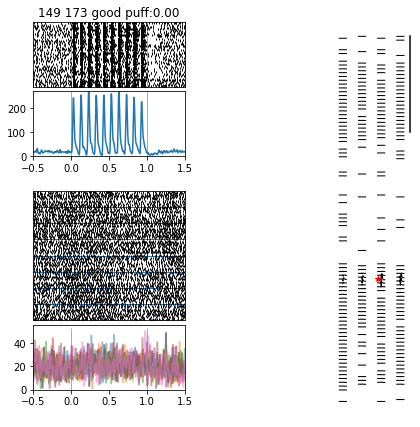

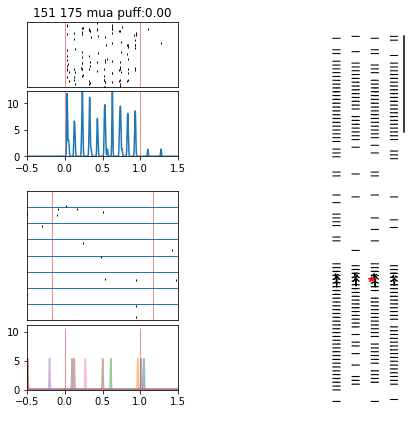

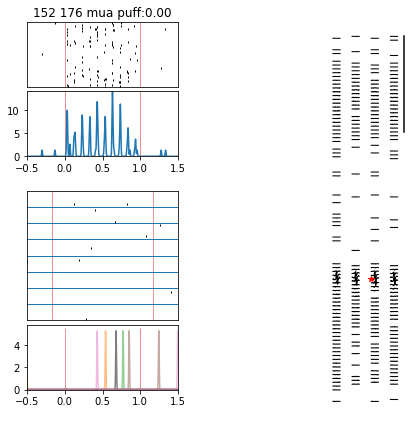

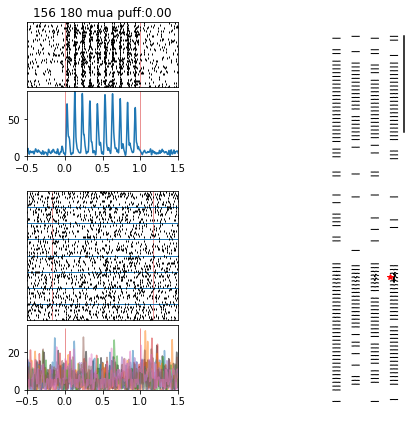

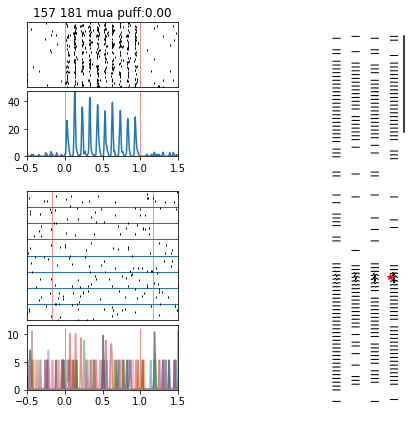

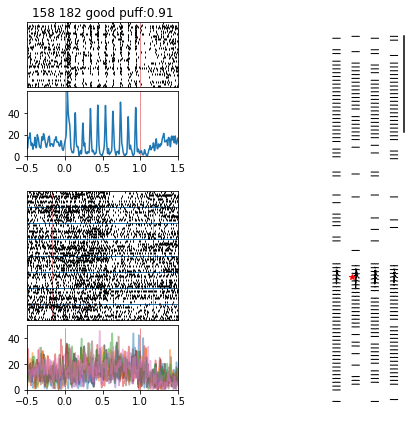

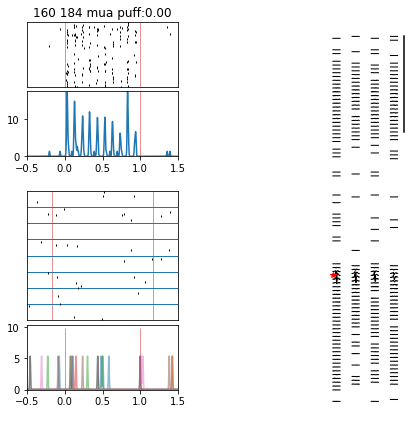

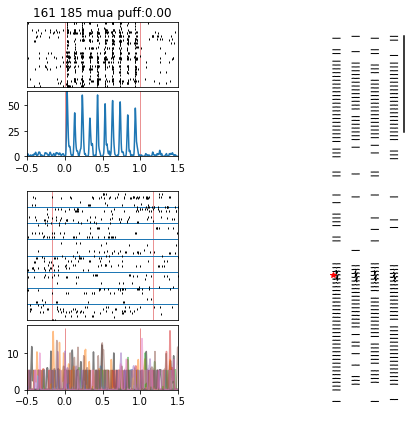

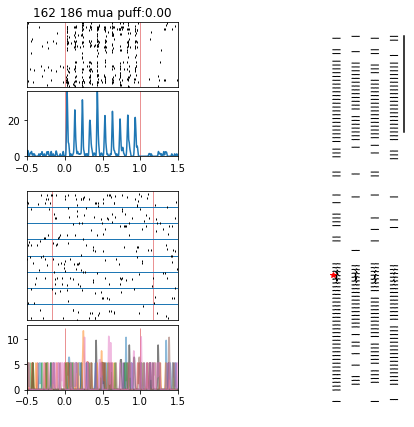

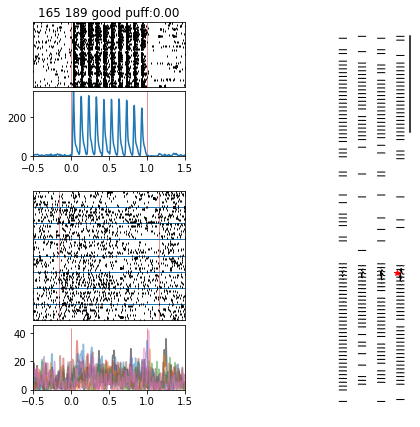

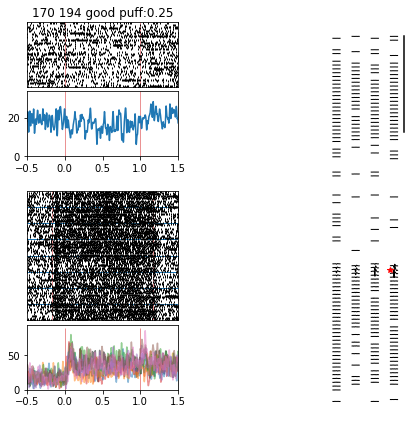

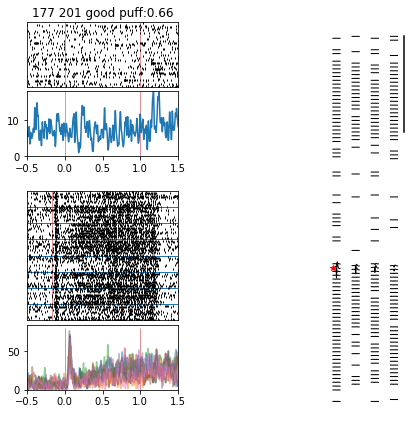

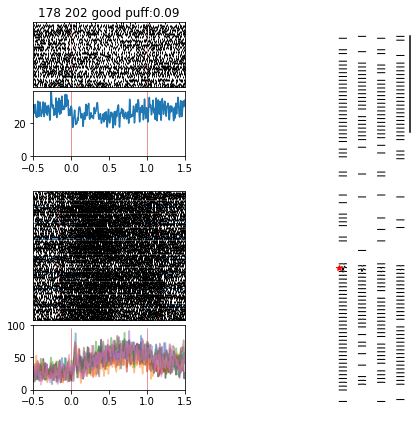

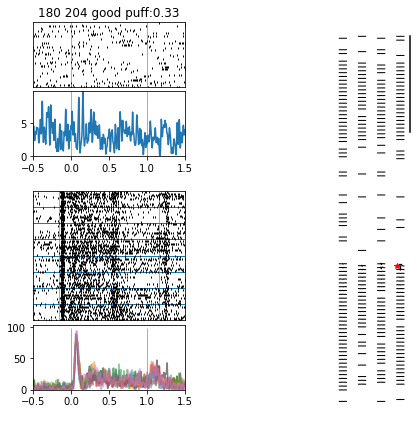

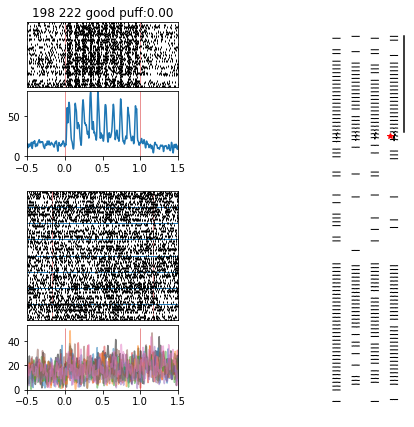

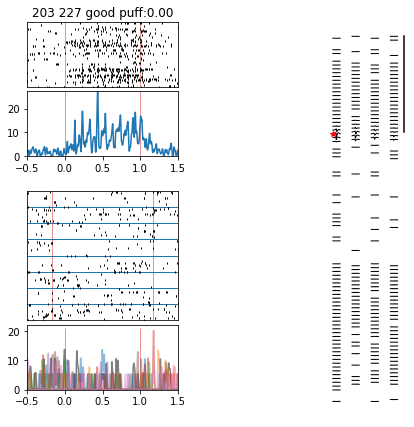

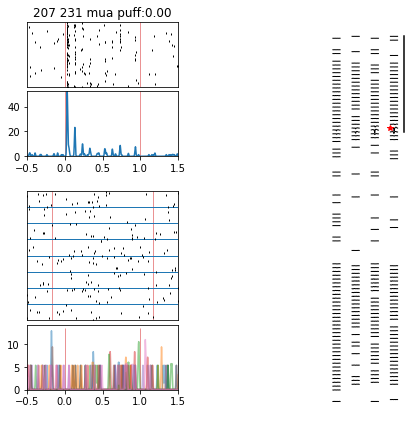

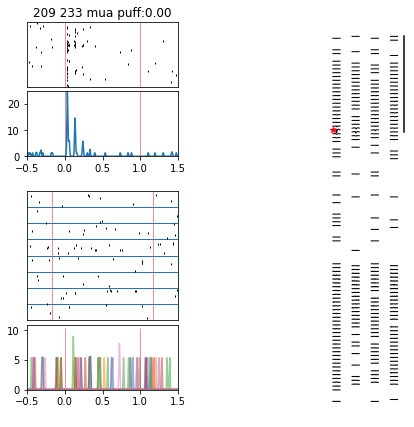

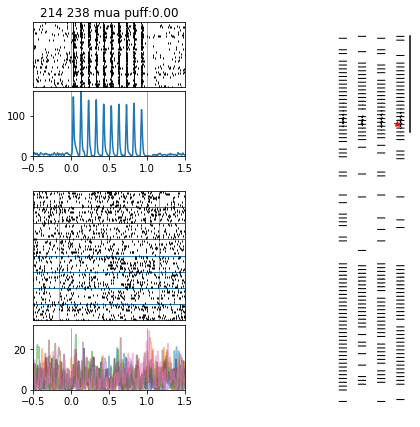

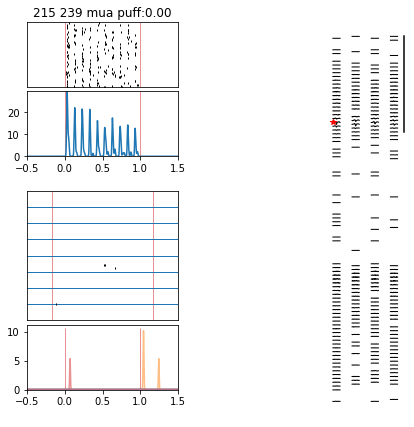

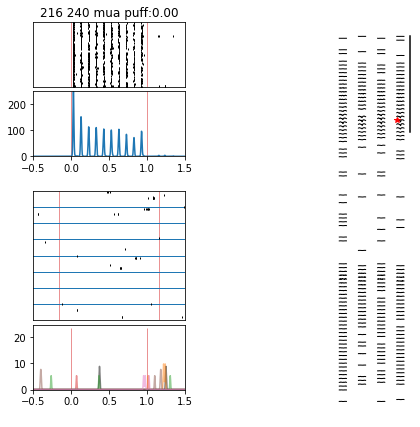

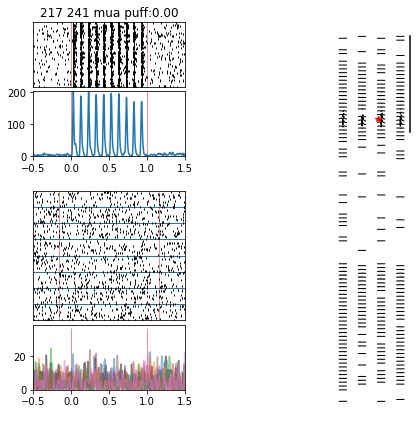

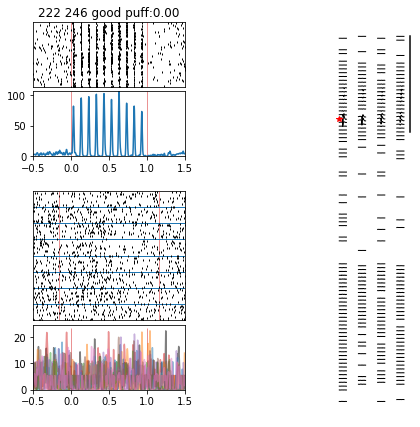

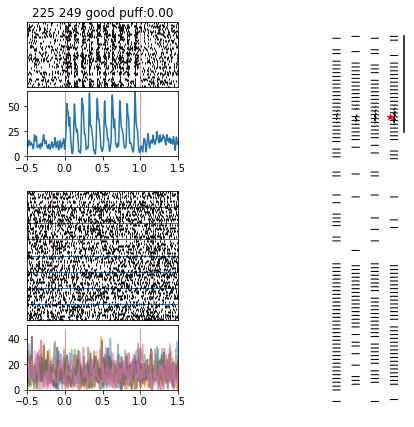

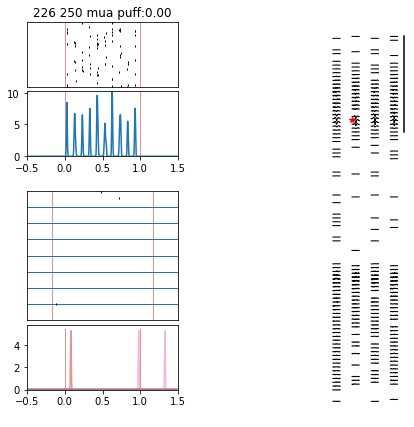

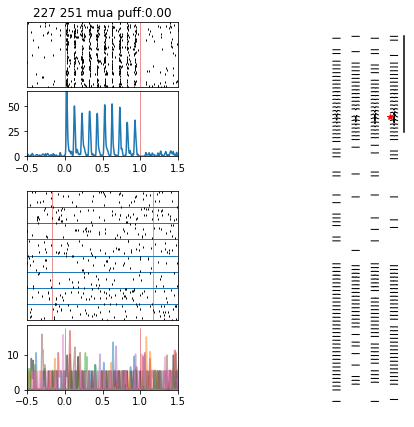

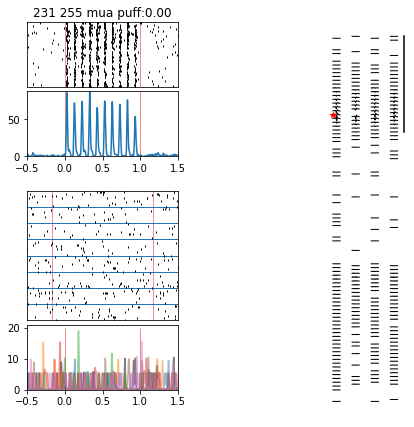

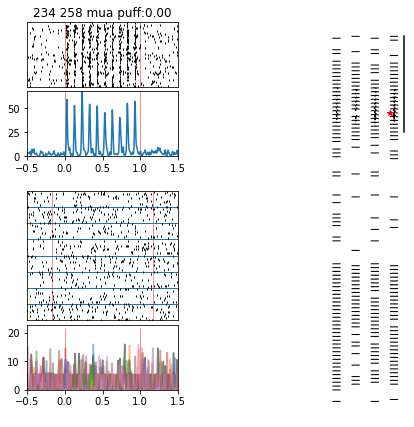

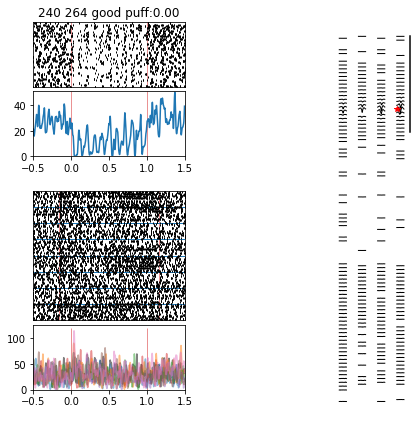

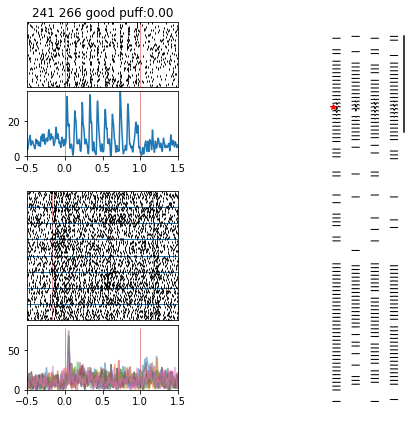

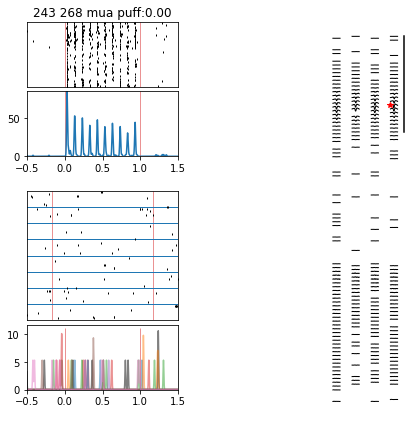

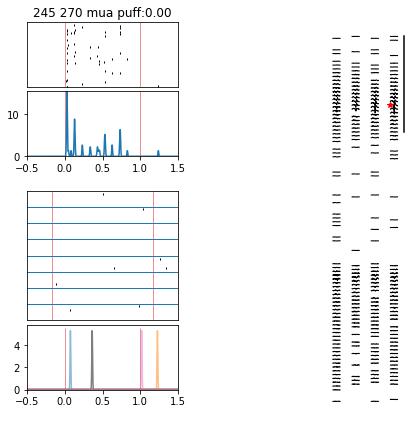

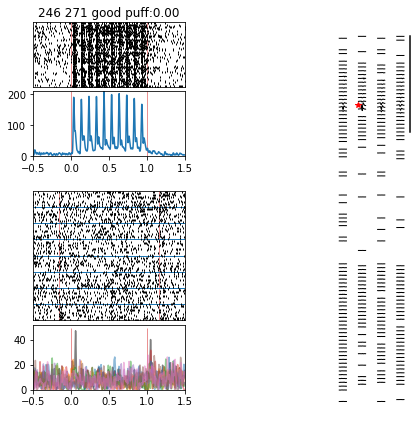

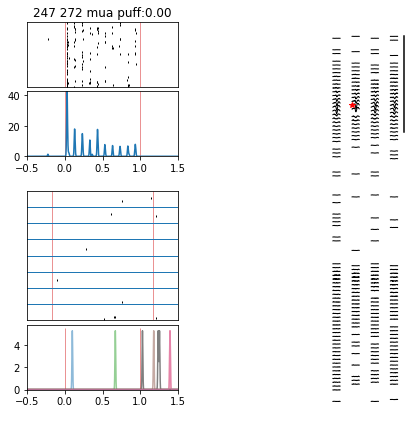

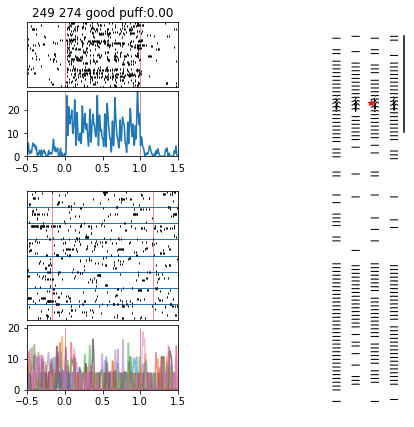

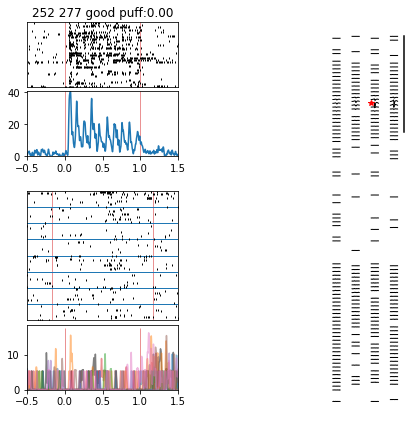

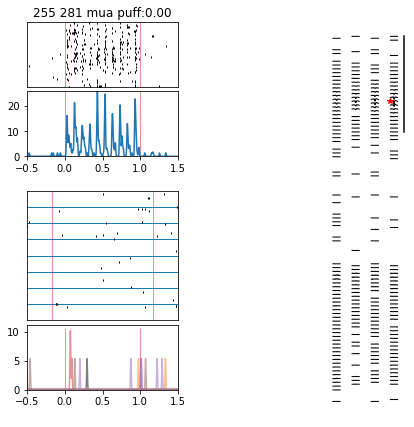

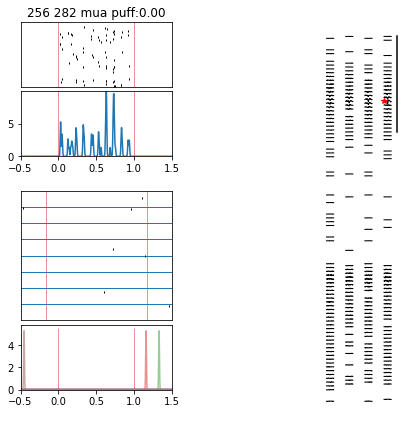

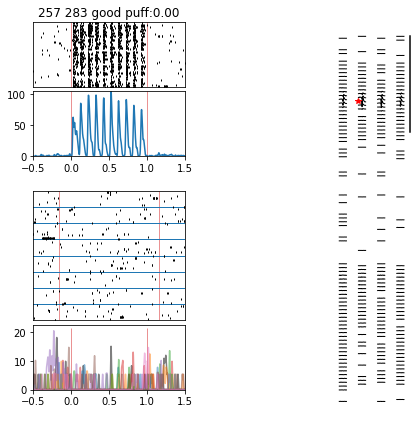

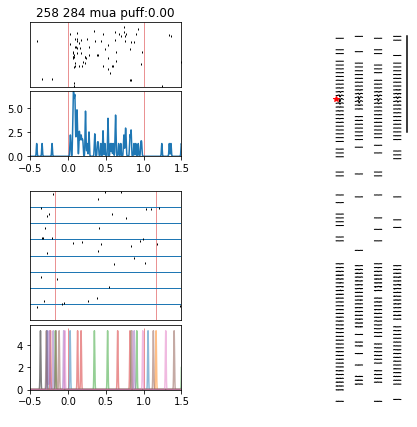

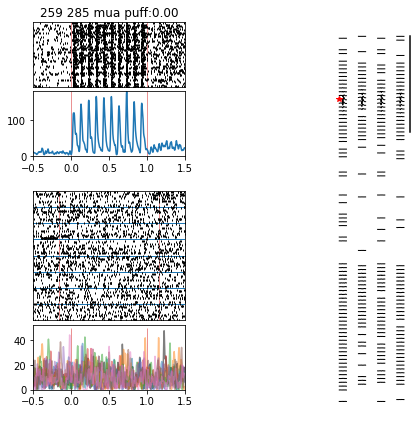

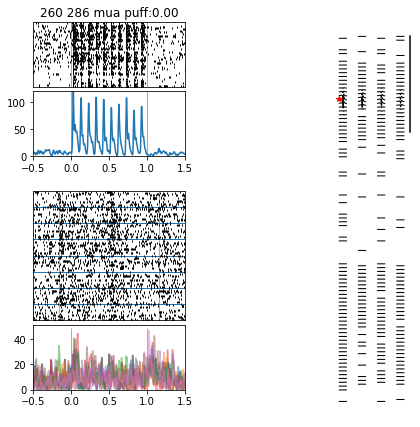

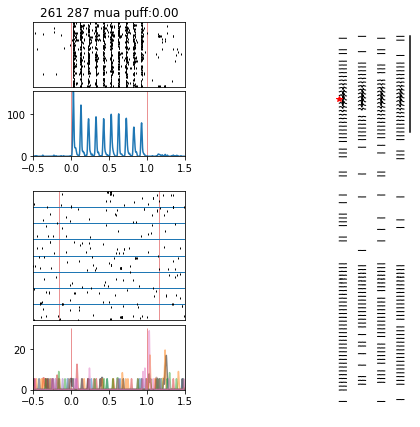

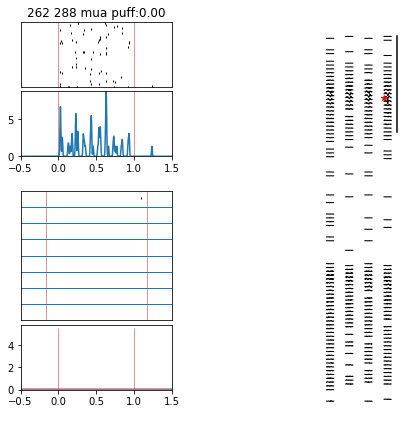

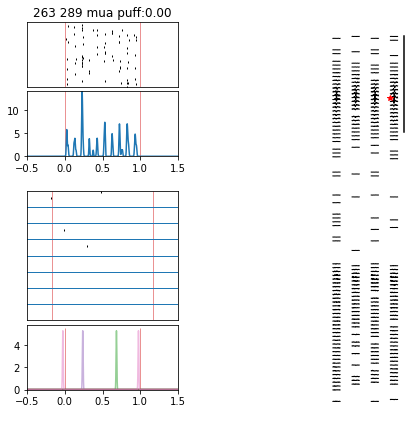

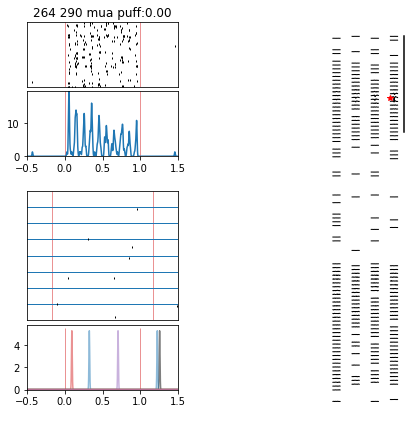

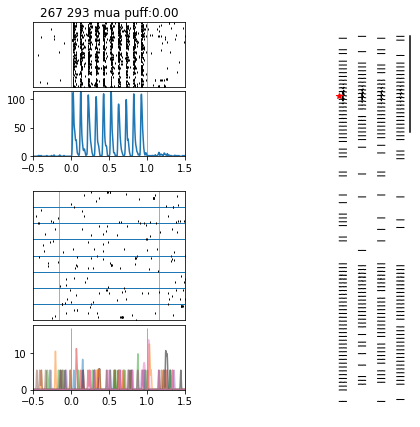

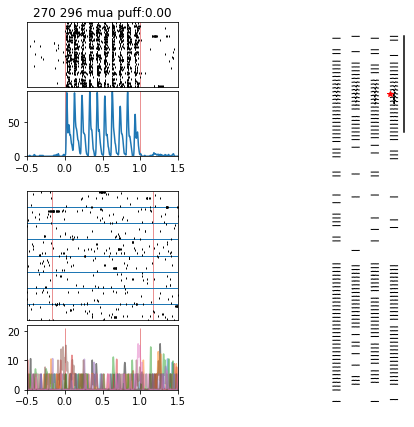

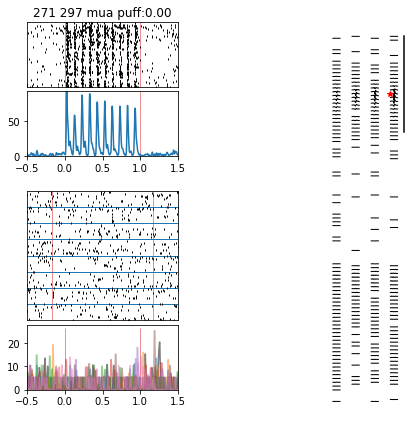

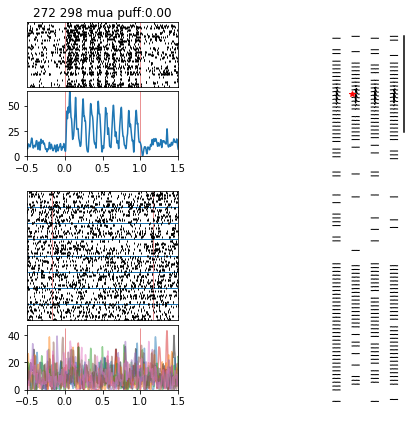

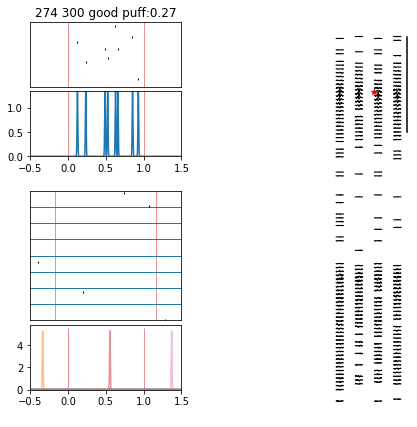

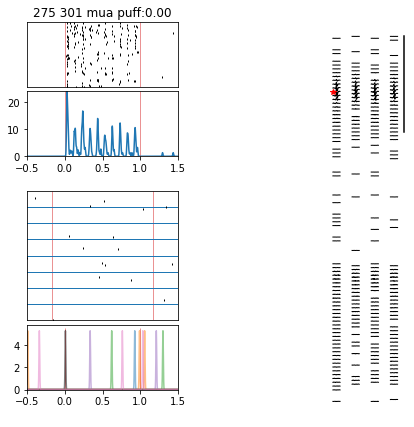

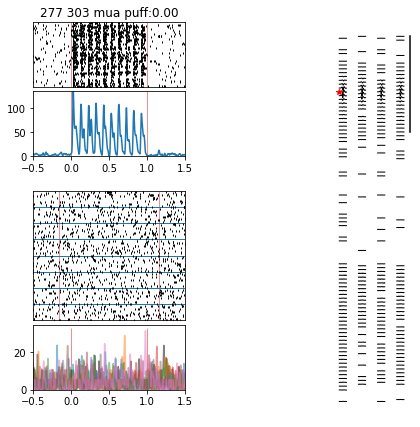

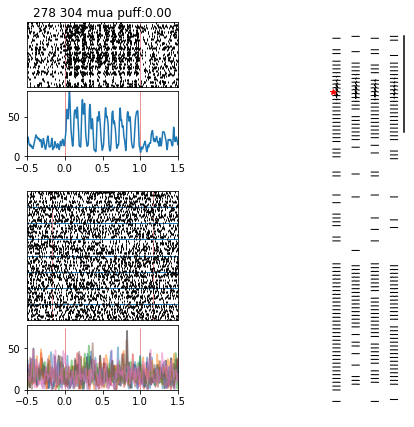

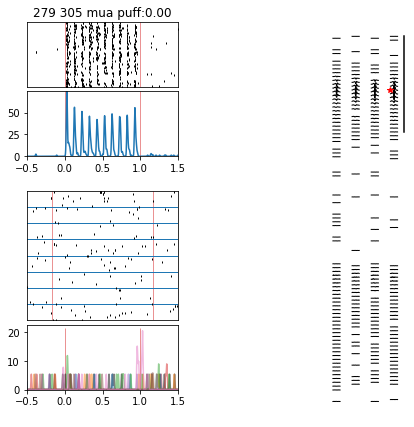

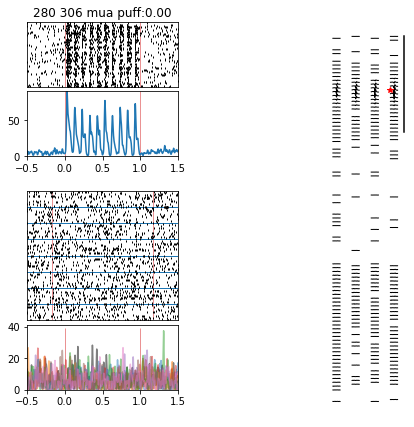

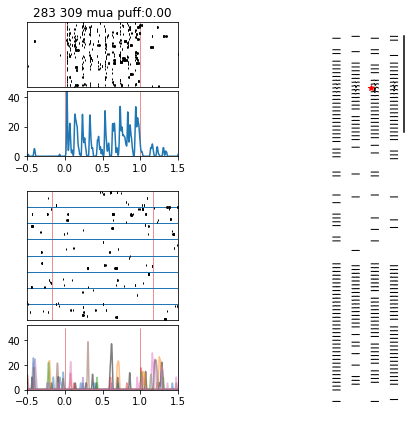

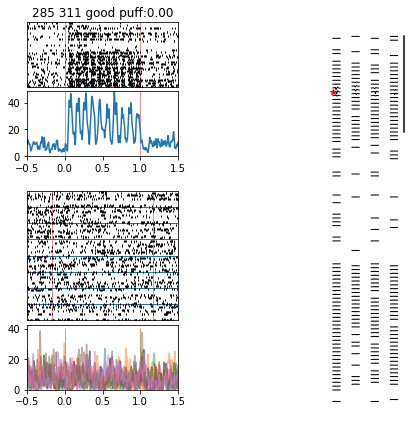

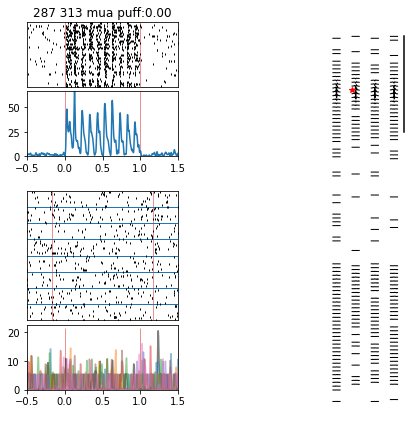

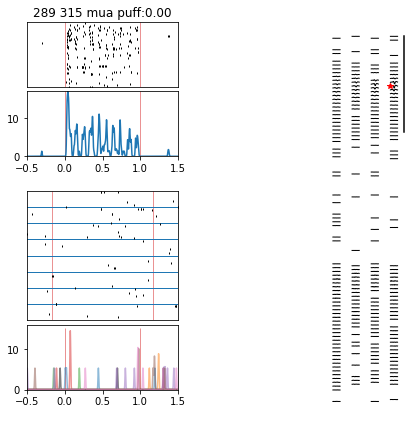

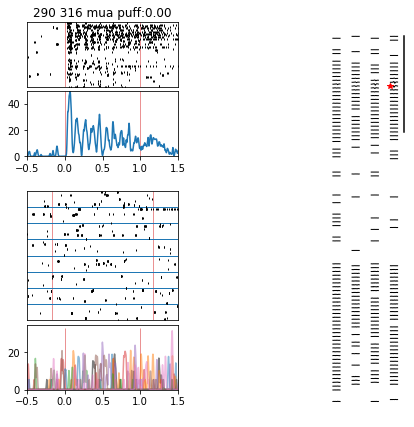

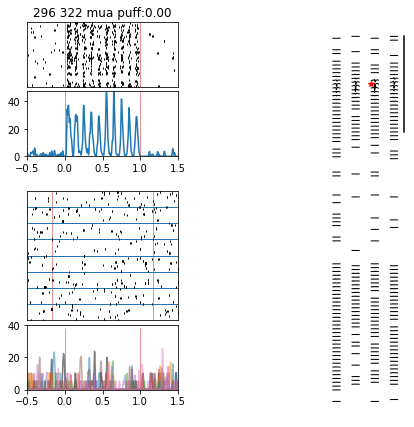

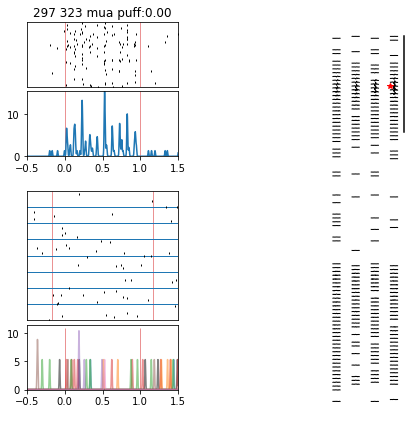

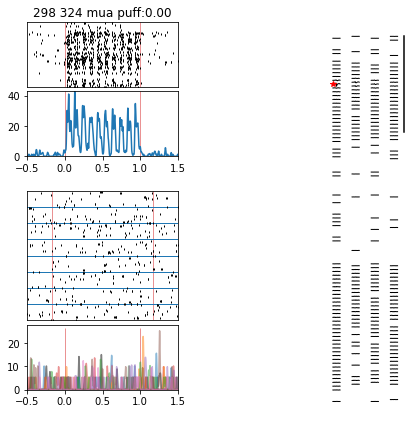

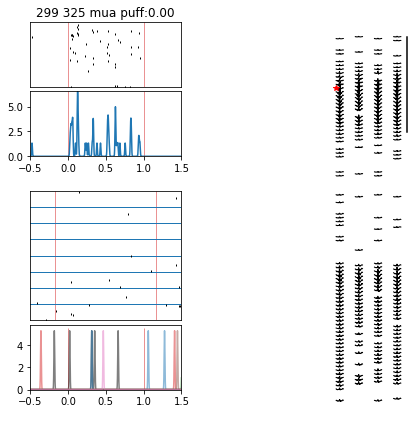

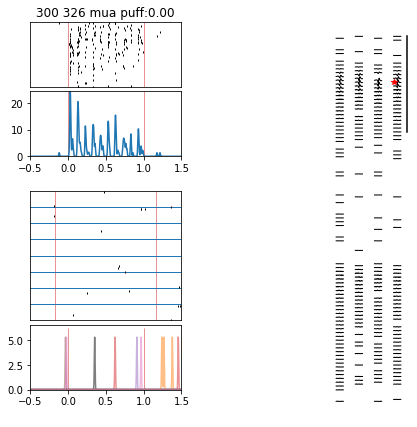

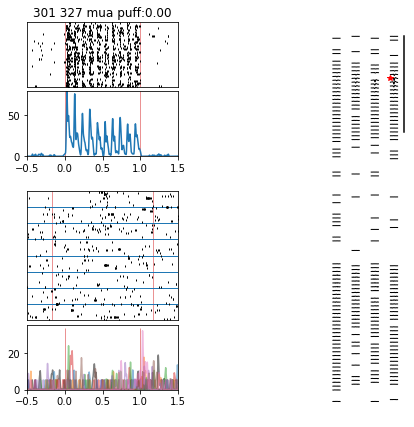

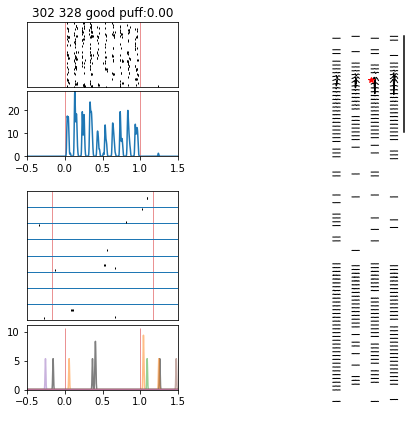

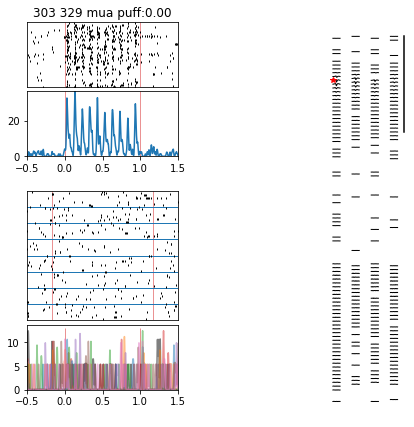

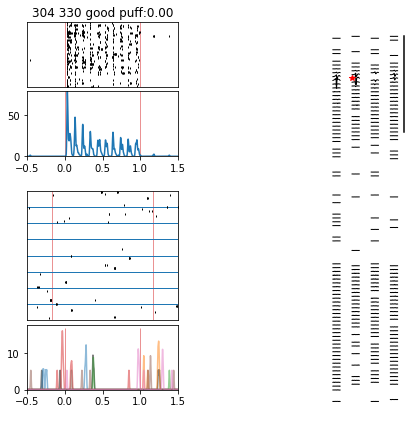

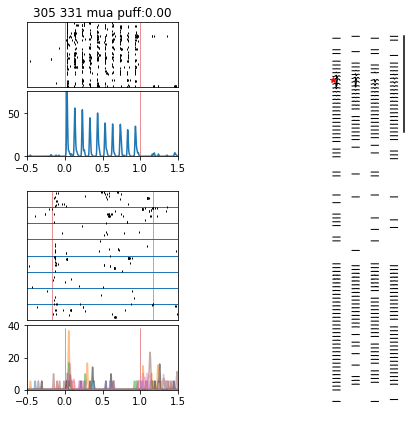

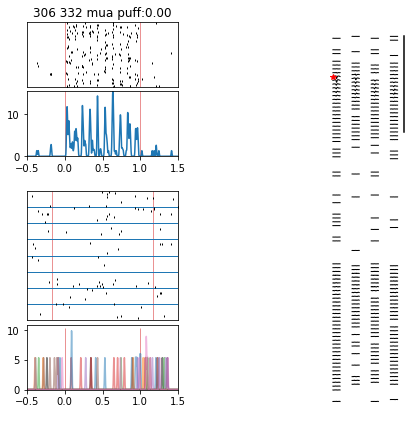

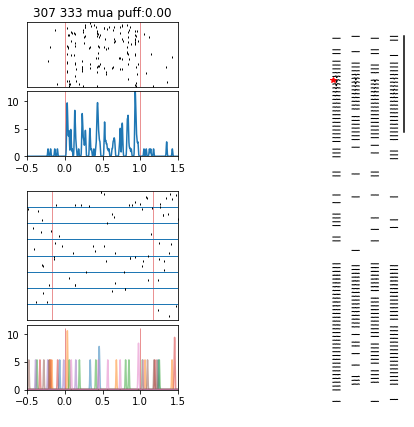

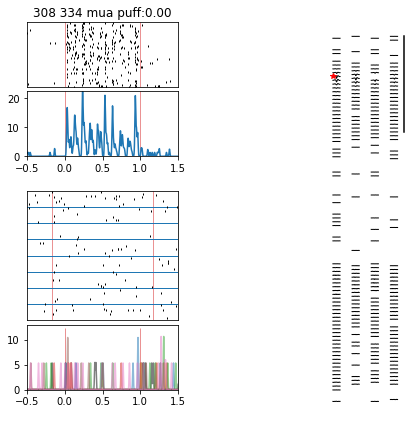

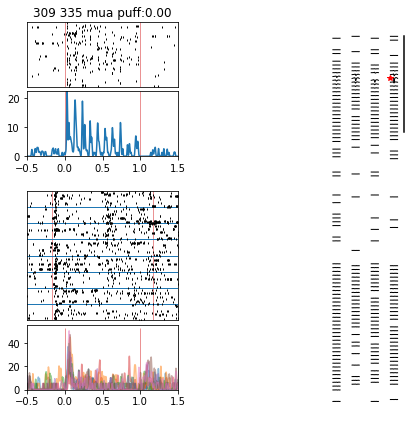

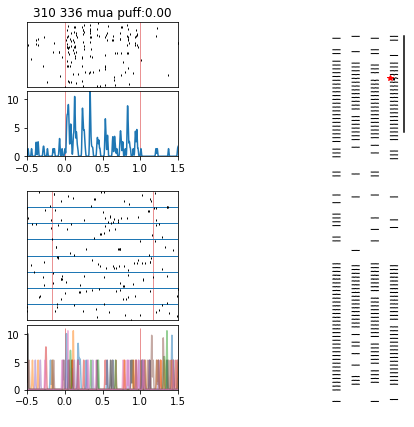

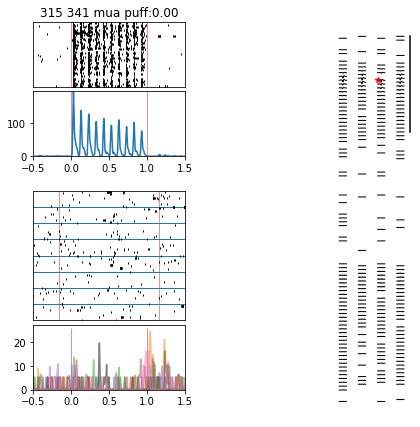

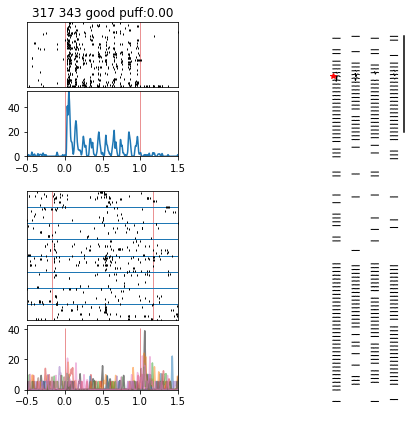

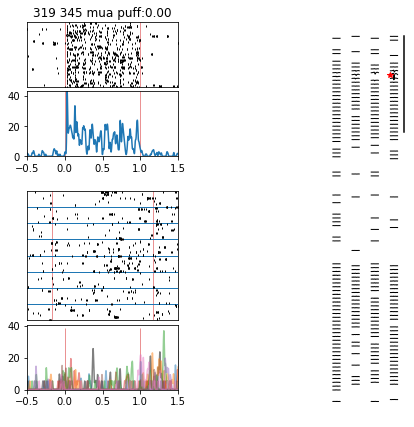

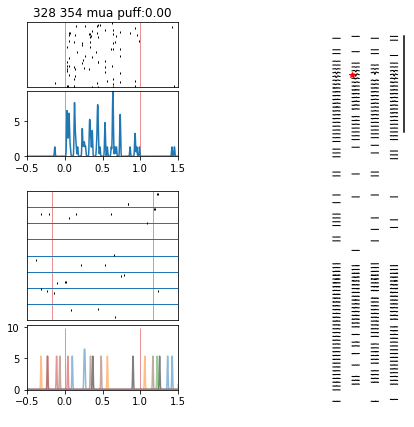

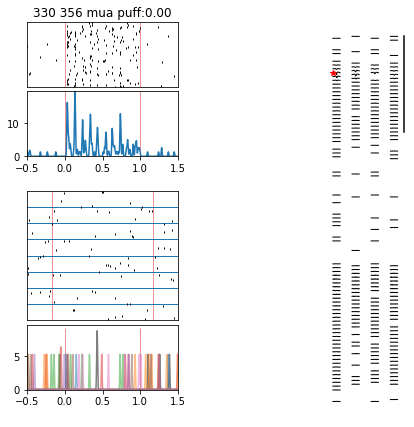

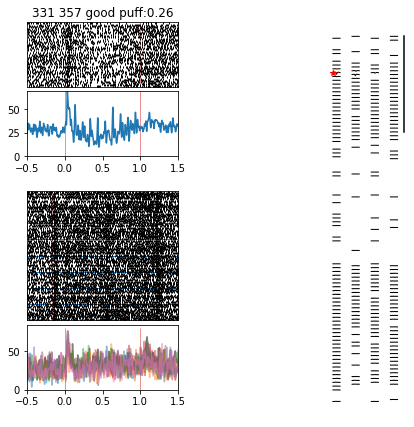

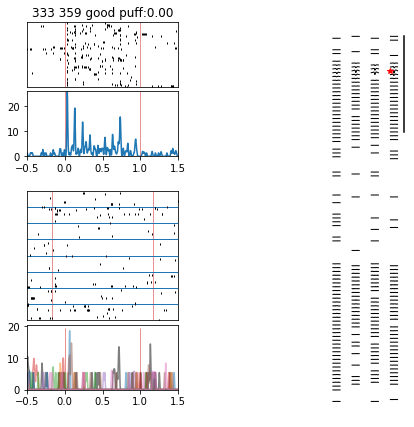

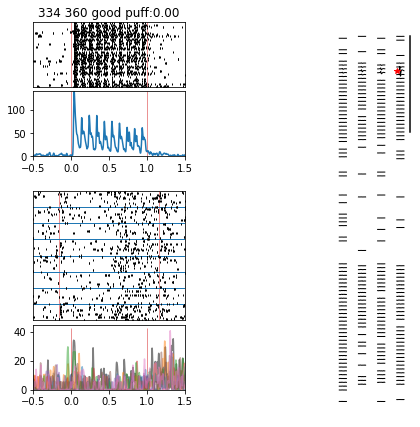

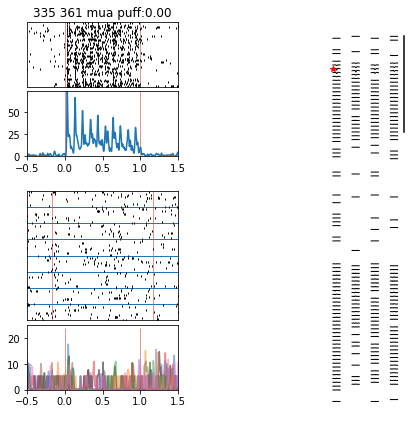

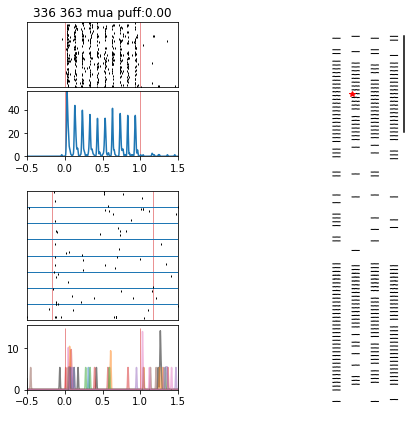

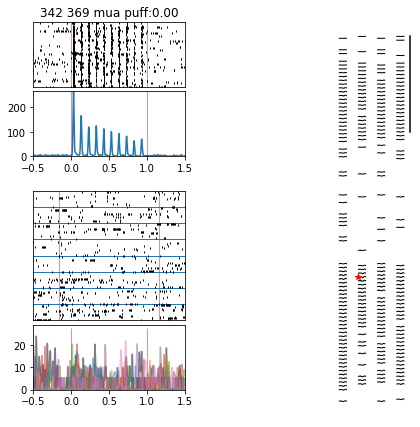

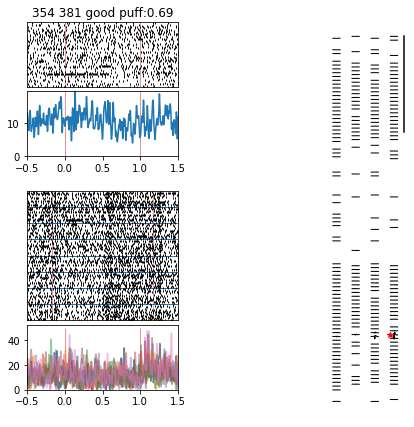

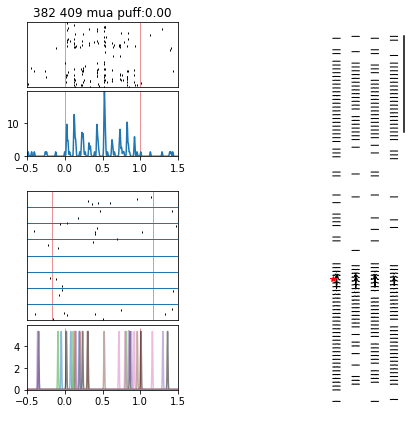

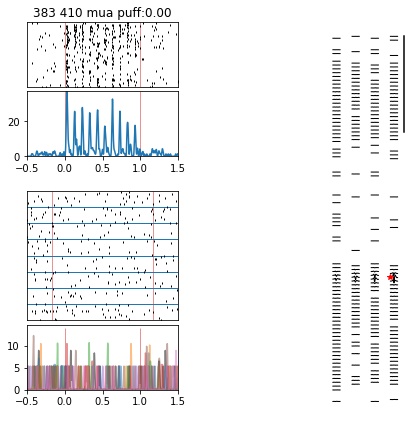

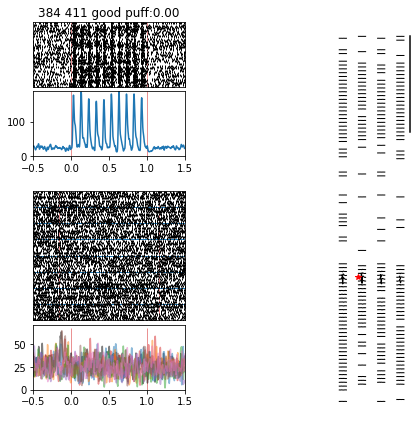

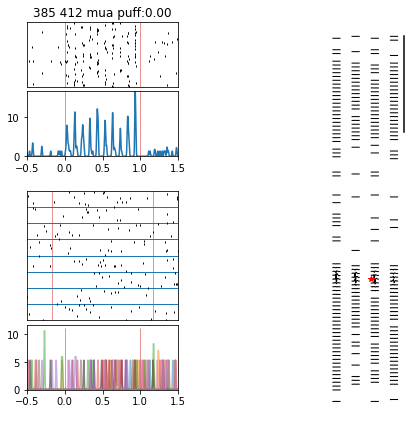

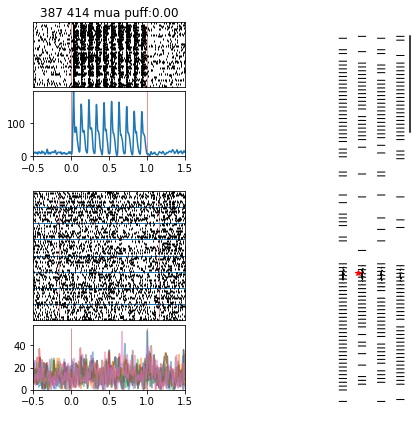

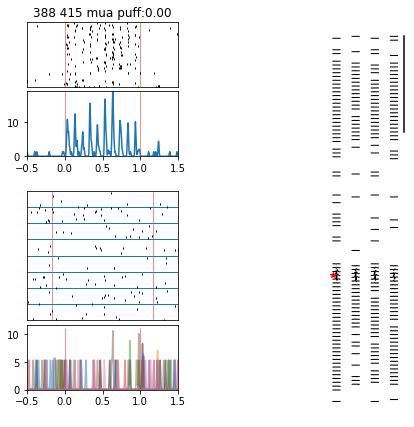

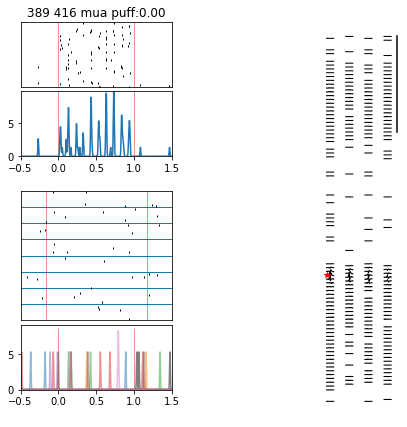

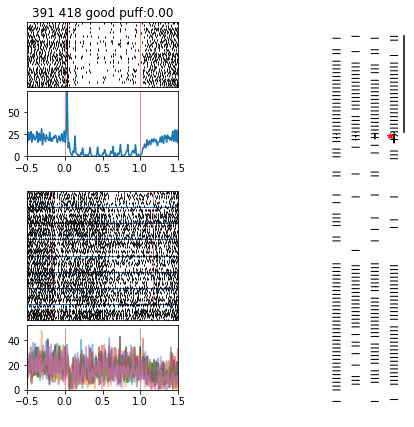

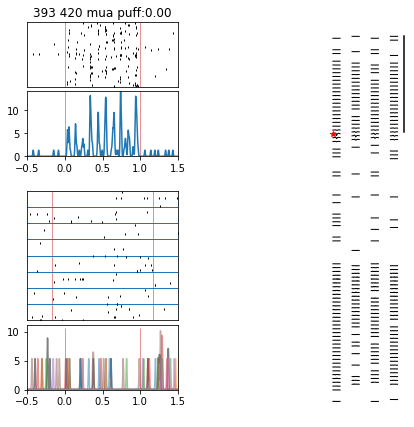

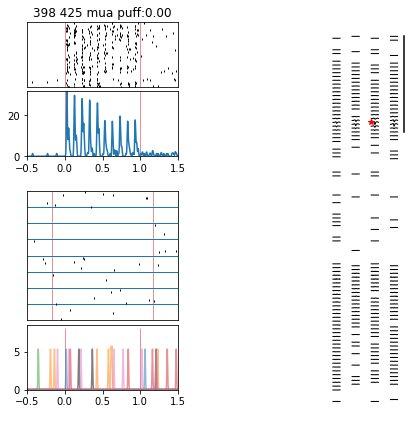

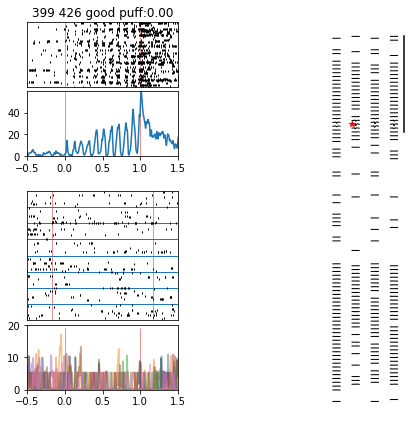

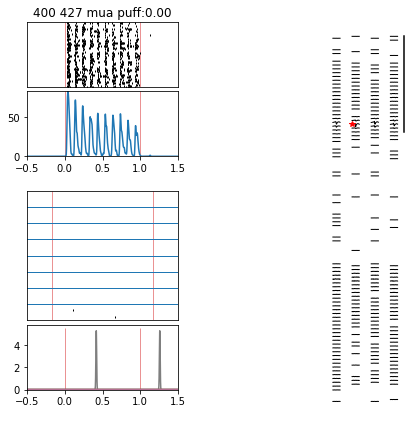

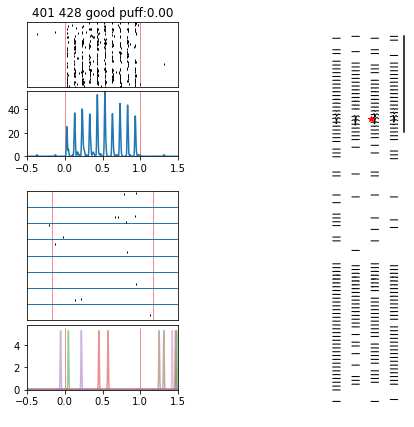

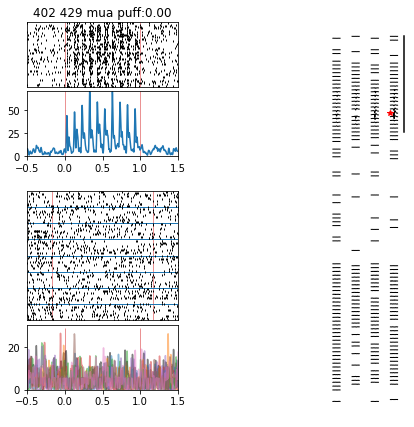

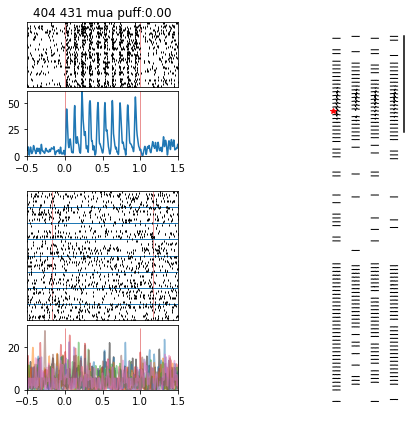

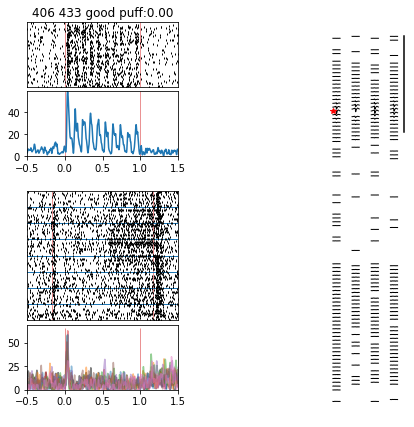

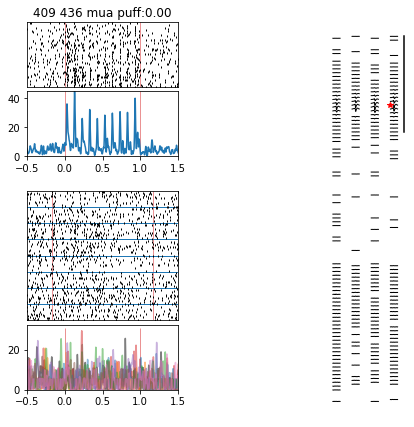

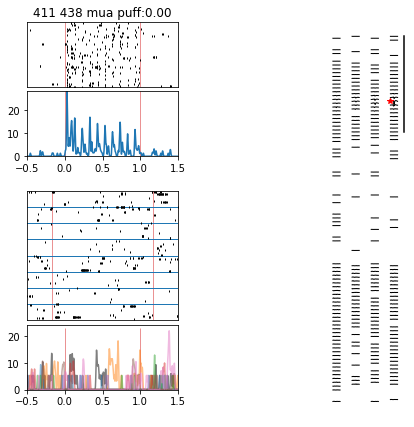

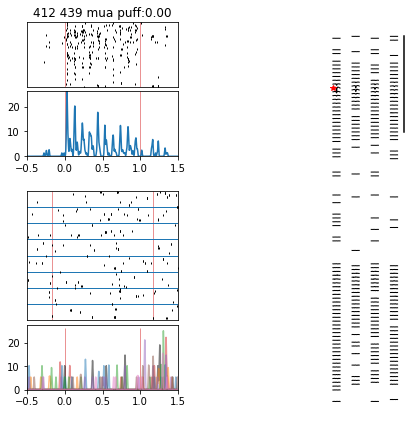

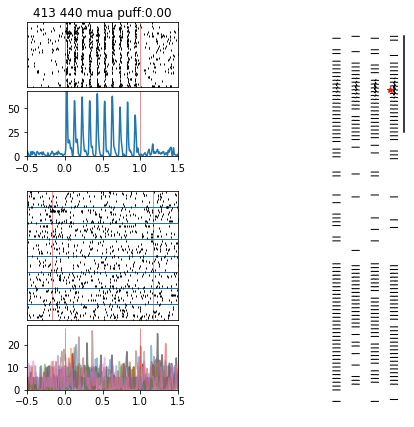

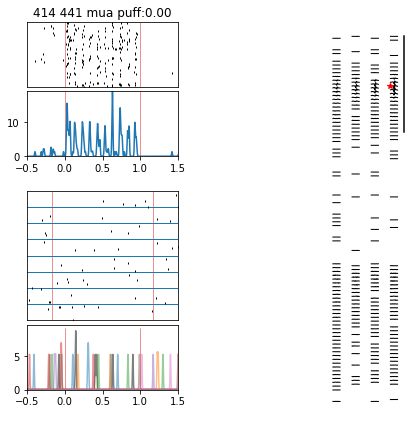

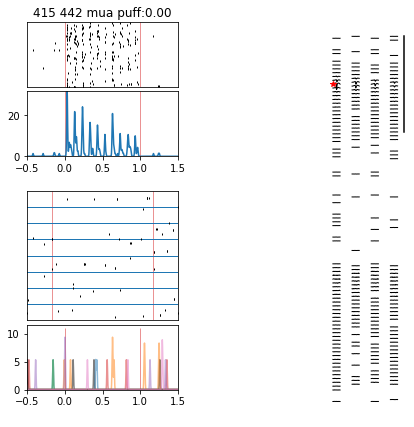

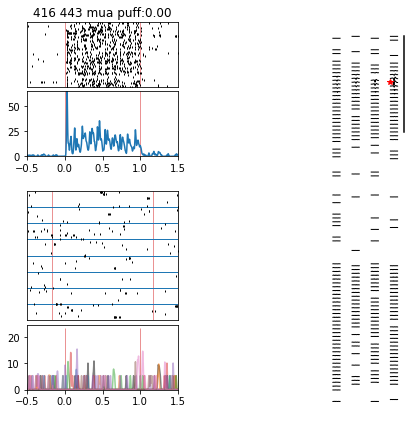

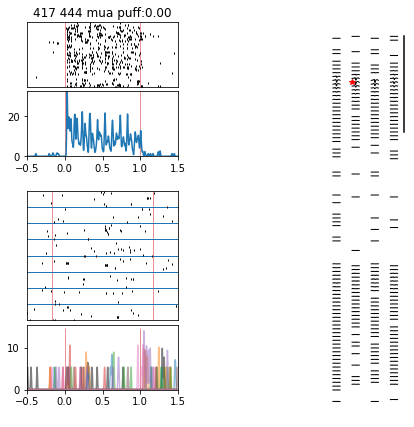

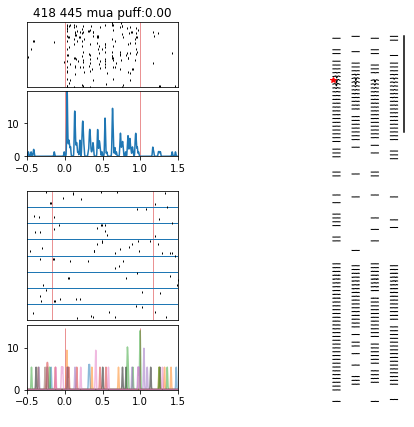

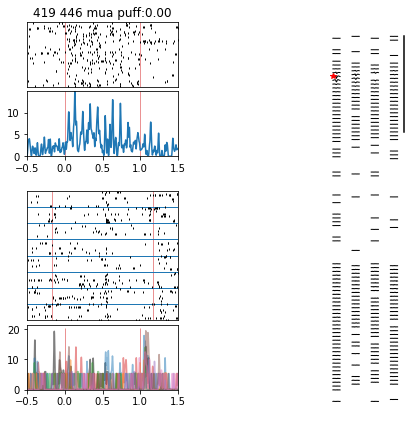

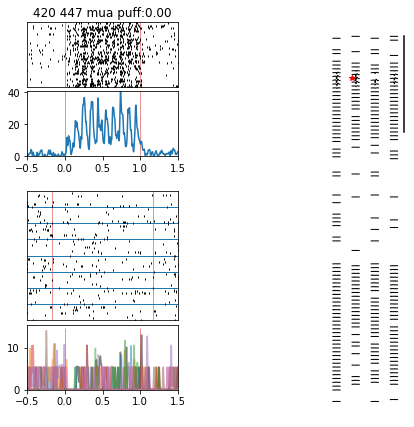

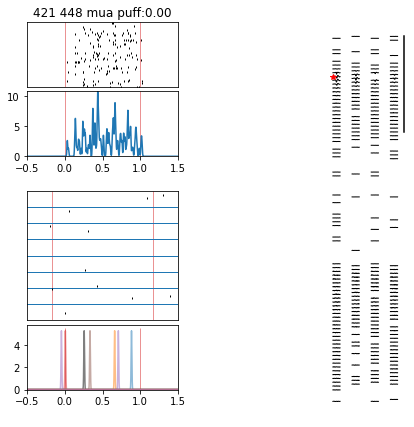

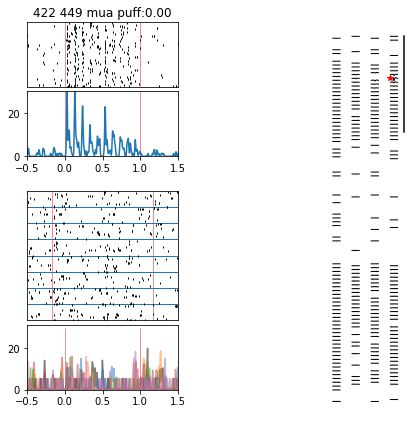

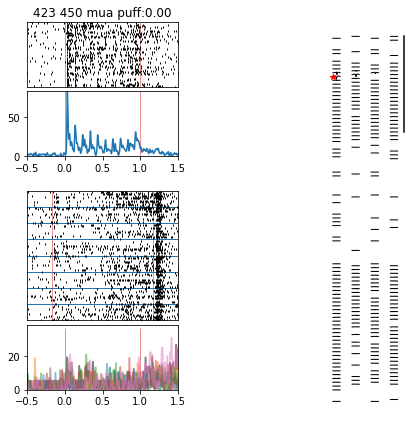

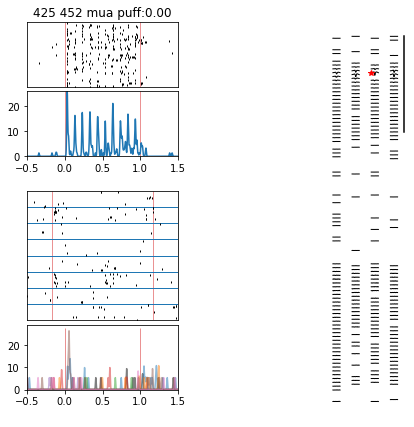

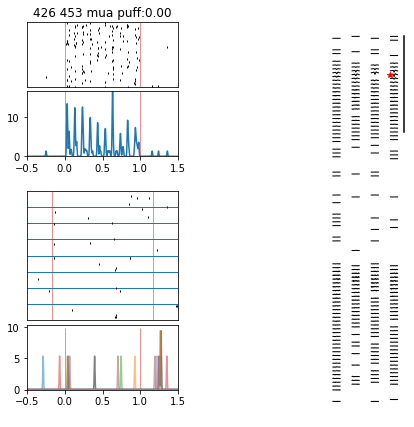

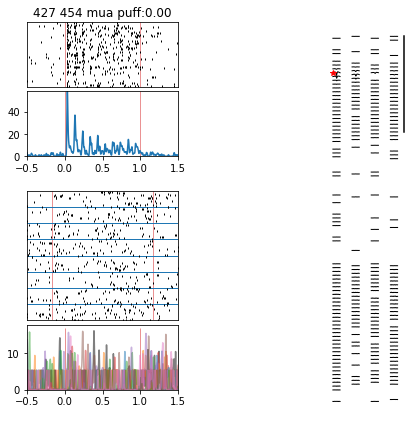

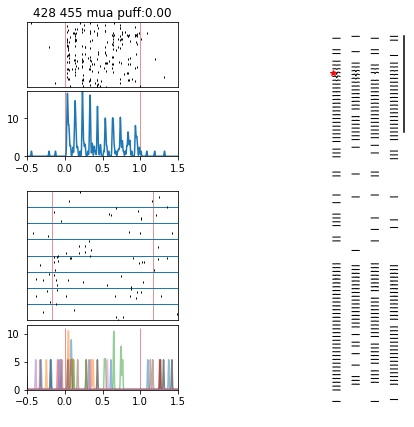

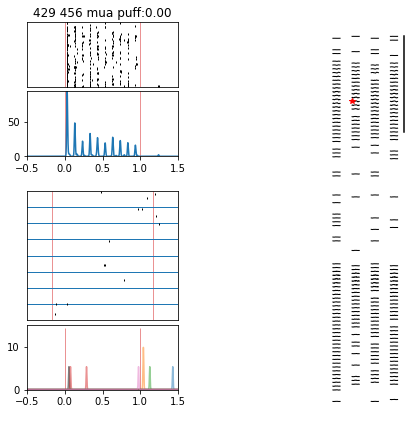

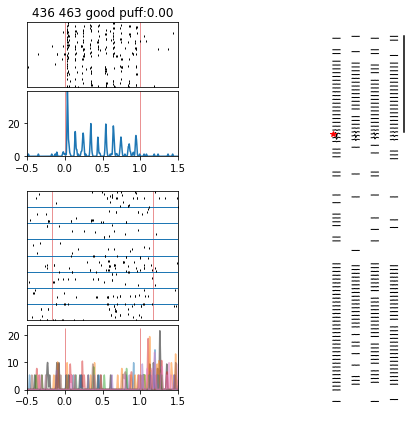

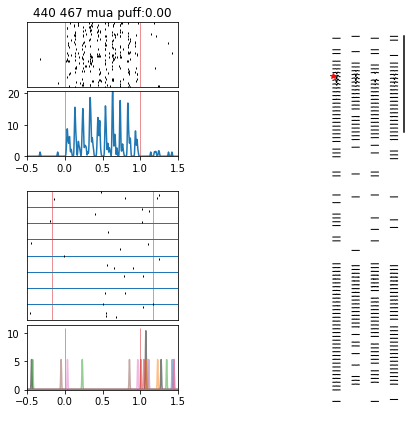

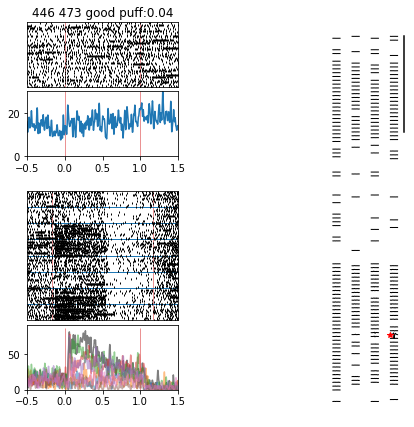

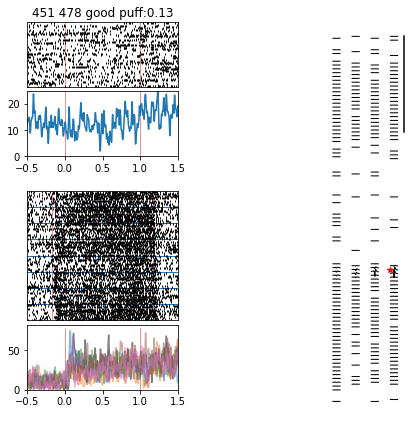

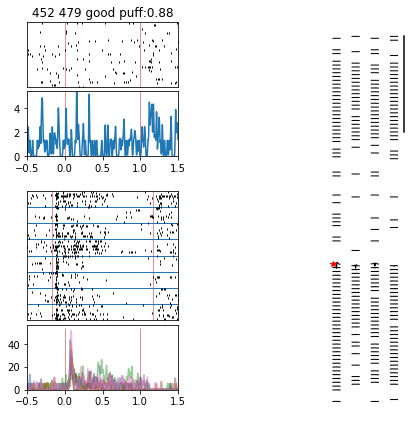

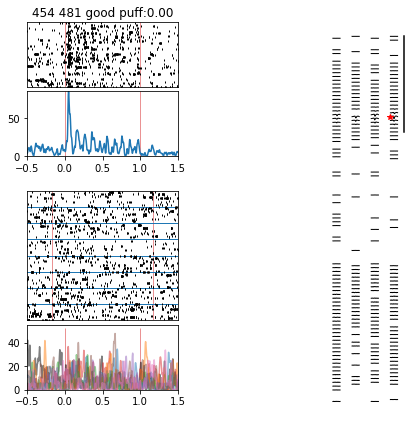

In [229]:
%matplotlib inline
for s in sel:
    fig1 = plt.figure(figsize=[6,6])
    interact_raster(s)

### Get random waveforms from a cluster

In [30]:
filename = bin_file.replace('ap.bin','lf.bin')
dat,meta = load_spikeglx_binary(filename)
srate = meta['imSampRate']

onsets,offsets = unpack_npix_sync(dat[:,-1],srate);
# filter photodiode pulses due to improper placement


In [42]:

idx = np.hstack([0,np.where(np.diff(event_on_off[:,0],axis = 0)>0.2)[0]+1])
idx

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
       520, 530, 540, 550, 560, 570, 580, 590], dtype=int64)

In [43]:
plt.figure()
event_on_off = np.vstack([onsets[7],offsets[7]]).T
print(np.diff(event_on_off[:,0],axis = 0))
plt.vlines(event_on_off[:,0],i,i+0.5)
idx = np.hstack([0,np.where(np.diff(event_on_off[:,0],axis = 0)>0.2)[0]+1])
plt.vlines(event_on_off[idx,0],0,1+0.5,'r')



[ 0.0992  0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 22.148   0.0996  0.1     0.1     0.1     0.1     0.1     0.1     0.1
  0.1    10.1224  0.1     0.1     0.1     0.1     0.1     0.1     0.1
  0.1     0.1     6.1132  0.0992  0.1     0.1     0.1     0.1     0.1
  0.1     0.1     0.1     6.114   0.1     0.1     0.1     0.1     0.1
  0.1     0.1     0.1     0.1     2.1044  0.0988  0.1     0.1     0.1
  0.1     0.1     0.1     0.1     0.1    26.1536  0.0992  0.1     0.1
  0.1     0.1     0.1     0.1     0.1     0.1     2.1064  0.0996  0.1
  0.1     0.1     0.1     0.1     0.1     0.1     0.1    14.13    0.0996
  0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     2.1092
  0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
  2.1052  0.0996  0.1     0.1     0.1     0.1     0.1     0.1     0.1
  0.1     2.104   0.0992  0.1     0.1     0.1     0.1     0.1     0.1
  0.1     0.1    42.1856  0.0996  0.1     0.1     0.1     0.1     0.1
  0.1     0.1 

dict_keys([0, 1, 2, 3, 4, 7, 8, 9])

<IPython.core.display.Javascript object>


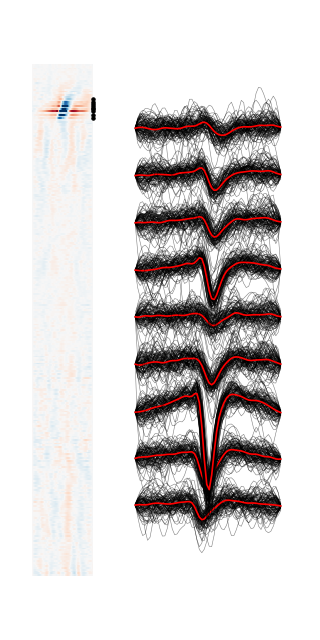

In [14]:
# get random sample of the waveforms for each cluster
filename = bin_file
dat,meta = load_spikeglx_binary(filename)
srate = meta['imSampRate']

iunit = 357
waves = get_random_waveforms(dat,
                             np.array(chmap.ichan),
                             (spks.ts.iloc[iunit]*srate).astype(int),
                            npre = 30,npost=30)
mwaves = waves.mean(axis=0) # mean waveforms
ptb = mwaves.max(axis=0) - mwaves.min(axis=0) # peak to baseline per channel 
waveidx = np.where(np.abs((ptb-np.mean(ptb))/np.std(ptb))>1)[0] # "active" channels

# plot the figure
fig = plt.figure(figsize=[4,8])
axmean = fig.add_axes([0.1,0.1,0.2,0.8])
plt.axis('off')
axwaves = fig.add_axes([0.4,0.1,0.5,0.8])
plt.axis('off')

plt.sca(axmean)
plt.imshow(mwaves.T,cmap='RdBu_r',aspect = 'auto',origin='bottom',clim=[-20,20])
plt.plot(np.ones_like(waveidx)*mwaves.shape[0],waveidx,'.k')
offset = 50
plt.sca(axwaves)

for i,ich in enumerate(waveidx):
    plt.plot(waves[:,:,ich].T+
             offset*i,alpha = 0.5,lw=0.5,color = 'k')
    plt.plot(waves[:,:,ich].mean(axis=0).astype(np.float32)+
             offset*i,color='r');
